In [1854]:
import yfinance as yf
import pandas as pd
import warnings
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import pandas_ta as pta
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV


In [1855]:
keras.utils.set_random_seed(69)
np.random.seed(69)
random.seed(69)
tf.random.set_seed(69)

In [1856]:
tickers_dict = {
    'MNST': [2004, None],
    'NFLX': [2011, None],
    'BIIB': [2008, None],
    'AMZN': [2010, None],
    'META': [2013, None],
    'NVDA': [2016, None],
    'AAPL': [2006, None],
    'SBUX': [2005, None],
    'INTC': [2002, None],
}


In [1857]:
tickers = yf.Tickers(list(tickers_dict.keys()))

df = pd.DataFrame()
for ticker in list(tickers_dict.keys()):
    start = datetime.datetime(tickers_dict[ticker][0],1,1, tzinfo=datetime.UTC)
    end = datetime.datetime.now(datetime.UTC)

    if tickers_dict[ticker][1] != None:
        end = datetime.datetime(tickers_dict[ticker][1],1,1, tzinfo=datetime.UTC)

    warnings.filterwarnings("ignore")
    history = yf.Ticker(ticker).history(start=start, end=end, period="max")
    history['MFI'] = pta.mfi(history.High, history.Low, history.Close, history.Volume)
    warnings.resetwarnings()

    history['RSI'] = pta.rsi(history.Close)
    history['CCI'] = pta.cci(history.High, history.Low, history.Close)
    history['AO'] = pta.ao(history.High, history.Low)
    history = pd.concat([history, pta.macd(history.Close)], axis=1)
    history = pd.concat([history, pta.stoch(history.High, history.Low, history.Close)], axis=1)
    history = pd.concat([history, pta.adx(history.High, history.Low, history.Close)], axis=1)
    
    
    history['Tomorrow'] = history['Close'].shift(-1)
    history['Target'] = (history['Tomorrow'] > history['Close']).astype(int)
    
    
    df = pd.concat([df, history], axis=0)


df.reset_index(inplace=True) 

# Set data
data = df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Tomorrow'], axis='columns').dropna()

data = data.reset_index(drop=True)


In [1858]:
data_arr = np.array(data)

X = data_arr[:, :-1]
y = data_arr[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)



In [1859]:
# Model
model = RandomForestClassifier(random_state=69, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=69)

In [1860]:
# Predictions
predictions = model.predict(X_test)
predictions = predictions.squeeze()

In [1861]:
#Initial Performance
print('Precision:' + str(precision_score(y_test, predictions)))
print('Precision negative:' + str(precision_score(1 - y_test, 1 - predictions)))

print('Recall:' + str(recall_score(y_test, predictions)))
print('Accuracy:' + str(accuracy_score(y_test, predictions)))
print('F1-score:' + str(f1_score(y_test, predictions)))

Precision:0.5164700098328416
Precision negative:0.49809038828771485
Recall:0.5712343665035345
Accuracy:0.5084604715672677
F1-score:0.5424735347276013


## Data Imbalance

In [1862]:
# Check for data imbalance
np.unique(data_arr[:, -1], return_counts=True) 

(array([0., 1.]), array([17430, 18616]))

The data is balanced!

## Feature Selection

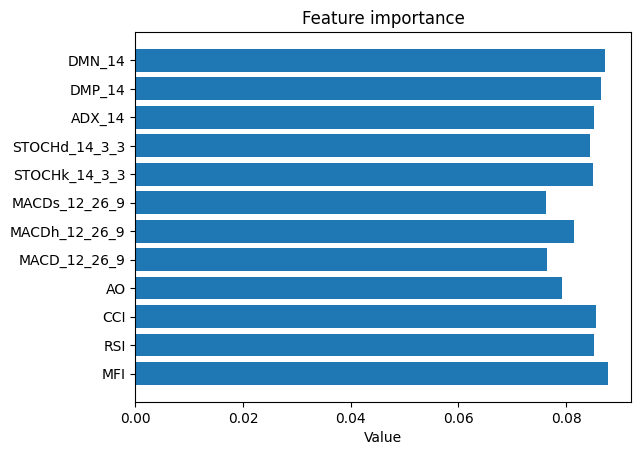

In [1863]:
# Display graph of feature importances
fig = plt.figure()

plt.barh(data.columns[:-1], model.feature_importances_)
plt.xlabel('Value')
plt.title('Feature importance')

plt.show()

In [1864]:
# We keep top 10 best features
N_FEATURES = 10
features_idx = np.flip(np.argsort(model.feature_importances_))[:N_FEATURES]

data.columns[features_idx]

columns = data.columns[features_idx].tolist()
columns.append('Target')

data_filtered = data.filter(columns, axis='columns')

data_filtered.head(3)

,MFI,DMN_14,DMP_14,CCI,ADX_14,RSI,STOCHk_14_3_3,STOCHd_14_3_3,MACDh_12_26_9,AO,Target
0,85.881994,9.897022,35.500667,124.421951,31.639839,76.755069,78.606999,83.561190,0.002024,0.025132,0
1,76.996015,18.468119,31.357299,62.043965,31.117425,63.186608,71.154093,78.029667,0.001222,0.025753,0
2,69.861994,20.868535,29.750107,17.377218,29.911939,60.729491,60.186811,69.982635,0.000466,0.024612,1


In [1865]:
data_filtered_arr = np.array(data_filtered)

X = data_filtered_arr[:, :-1]
y = data_filtered_arr[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Model
model = RandomForestClassifier(random_state=69, n_jobs=-1)
model.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)
predictions = predictions.squeeze()

#Feature selection performance
print('Precision:' + str(precision_score(y_test, predictions)))
print('Precision negative:' + str(precision_score(1 - y_test, 1 - predictions)))
print('Recall:' + str(recall_score(y_test, predictions)))
print('Accuracy:' + str(accuracy_score(y_test, predictions)))
print('F1-score:' + str(f1_score(y_test, predictions)))

Precision:0.5198716366329301
Precision negative:0.5023741690408358
Recall:0.5725938009787929
Accuracy:0.5122052704576976
F1-score:0.5449605382326304


We see a slightly better model.

## Hyperparameter tuning

In [1866]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]

# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree

criterion = ['gini', 'log_loss', 'entropy']


In [1867]:
params = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf':min_samples_leaf
}

In [1868]:
rc = RandomForestClassifier(random_state=69)

rc_cv = RandomizedSearchCV(estimator=rc, param_distributions=params, n_iter=100, cv=5, scoring='precision', random_state=69, n_jobs=-1)

rc_cv.fit(X_train, y_train)

/opt/anaconda3/envs/stock-predictor/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py:951: DeprecationWarning: This process (pid=60421) is multi-threaded, use of fork() may lead to deadlocks in the child.
  child_process = getattr(os, original_name)()  # fork
171064.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
171064.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
171064.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
171064.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
171064.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
171064.23s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
171064.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
171064.25s - pydevd: Sendin

In [ ]:
best_predictions = rc_cv.best_estimator_.predict(X_test)

best_predictions = best_predictions.squeeze()

precision = precision_score(y_test, best_predictions)
precision_neg = precision_score(1 - y_test, 1 - best_predictions)

print('Precision:' + str(precision))
print('Precision negative:' + str(precision_score(1 - y_test, 1 - best_predictions)))

print('Recall:' + str(recall_score(y_test, best_predictions)))
print('Accuracy:' + str(accuracy_score(y_test, best_predictions)))
print('F1-score:' + str(f1_score(y_test, best_predictions)))

print(rc_cv.best_params_)


Precision:0.5208290155440415
Precision negative:0.5115303983228512
Recall:0.6832517672648178
Accuracy:0.517753120665742
F1-score:0.591085499235564
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}


Although precision was slightly reduced, we get a big improvement with Recall and F1-score

## Stock predictor

In [ ]:
stock = 'MSFT'

In [ ]:
warnings.filterwarnings("ignore")
history = yf.Ticker(stock).history(start=datetime.datetime(datetime.datetime.today().year - 1, 1, 1, tzinfo=datetime.UTC), period="max")
history['MFI'] = pta.mfi(history.High, history.Low, history.Close, history.Volume)
warnings.resetwarnings()

history['RSI'] = pta.rsi(history.Close)
history['CCI'] = pta.cci(history.High, history.Low, history.Close)
history['AO'] = pta.ao(history.High, history.Low)
history = pd.concat([history, pta.macd(history.Close)], axis=1)
history = pd.concat([history, pta.stoch(history.High, history.Low, history.Close)], axis=1)
history = pd.concat([history, pta.adx(history.High, history.Low, history.Close)], axis=1)


history.reset_index(inplace=True) 

X_test_tomorrow = np.array(history.tail(1).filter(columns))

predictions_tomorrow = rc_cv.best_estimator_.predict(X_test_tomorrow)


In [ ]:
if predictions_tomorrow[0] == 1:
    print(f'{stock} stock will go up tomorrow with a probability of {precision*100}%')
else:
    print(f'{stock} stock will go down tomorrow with a probability of {precision_neg*100}%')



MSFT stock will go up tomorrow with a probability of 52.082901554404145%
